In [22]:
import os
os.chdir("/Users/isaganijulian/Documents/GitHub/Depop/Depop-Data-Project")

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.transform import DataCleaner

In [24]:
df = pd.read_csv('data/processed/cleaned.csv')

In [25]:
# Instantiate DataCleaner with the DataFrame
cleaner = DataCleaner(df)

# Apply only the convert_dates function
df = cleaner.convert_dates().get_data()


Finished converting date columns to datetime.


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date of sale              53 non-null     datetime64[ns]
 1   Time of sale              53 non-null     object        
 2   Date of listing           53 non-null     datetime64[ns]
 3   Bundle                    53 non-null     object        
 4   Brand                     53 non-null     object        
 5   Description               53 non-null     object        
 6   Size                      53 non-null     object        
 7   Item price                53 non-null     float64       
 8   Buyer shipping cost       53 non-null     float64       
 9   Total                     53 non-null     float64       
 10  Depop fee                 53 non-null     float64       
 11  Depop Payments fee        53 non-null     float64       
 12  Boosting fee            

In [27]:
# Info on data structure
print(df.info())

# Summary Stats
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date of sale              53 non-null     datetime64[ns]
 1   Time of sale              53 non-null     object        
 2   Date of listing           53 non-null     datetime64[ns]
 3   Bundle                    53 non-null     object        
 4   Brand                     53 non-null     object        
 5   Description               53 non-null     object        
 6   Size                      53 non-null     object        
 7   Item price                53 non-null     float64       
 8   Buyer shipping cost       53 non-null     float64       
 9   Total                     53 non-null     float64       
 10  Depop fee                 53 non-null     float64       
 11  Depop Payments fee        53 non-null     float64       
 12  Boosting fee            

In [28]:
# Column to identify how long an item took to sell
df['time_to_sell_days'] = (df['Date of sale'] - df['Date of listing']).dt.days
df['time_to_sell_days'].describe()

count     53.000000
mean      28.867925
std       35.664051
min        0.000000
25%        5.000000
50%       17.000000
75%       45.000000
max      179.000000
Name: time_to_sell_days, dtype: float64

### Univariate Analysis For Numerical Columns

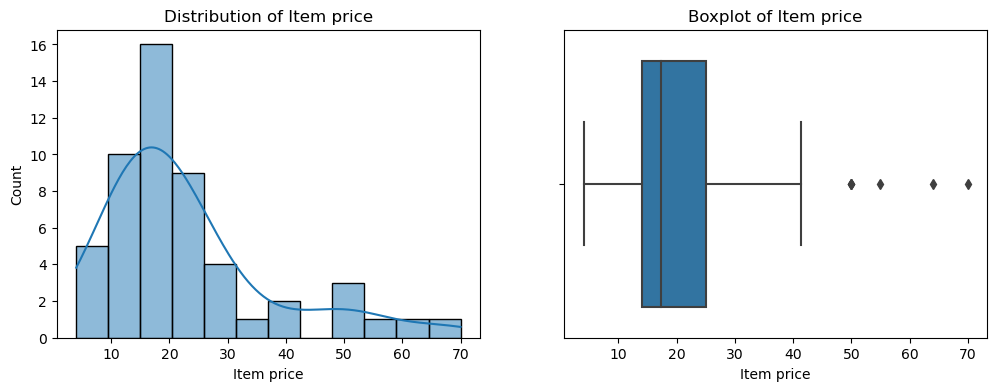

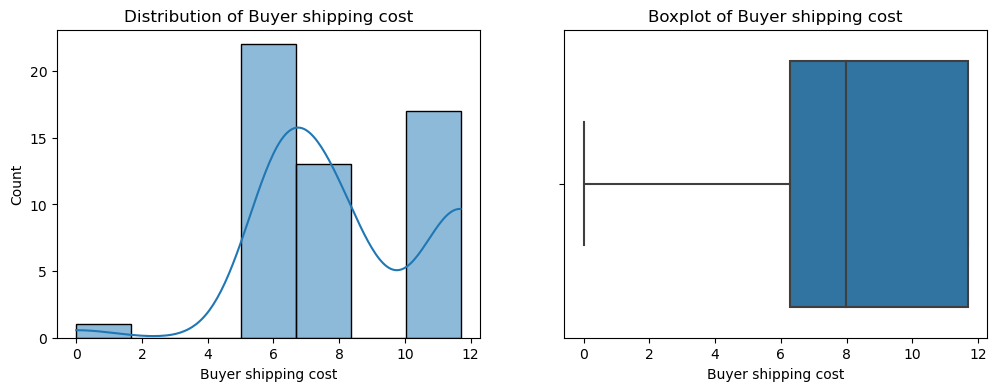

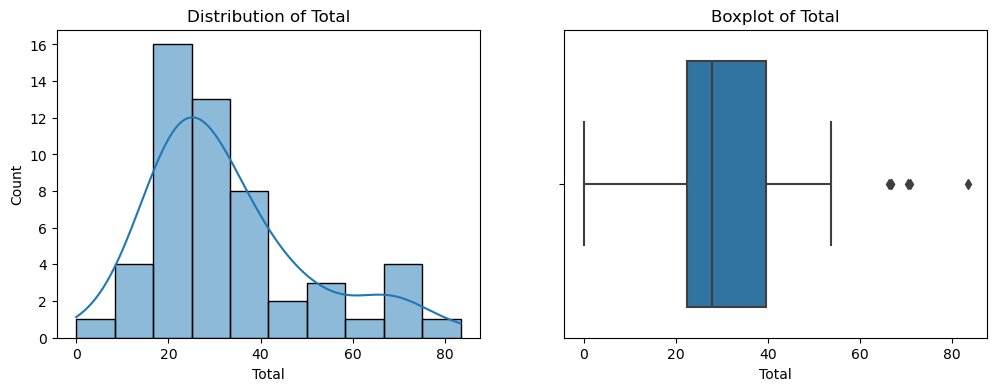

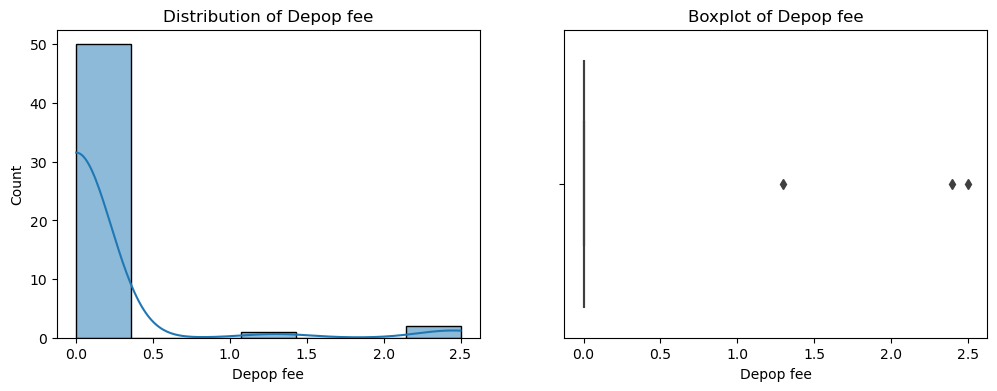

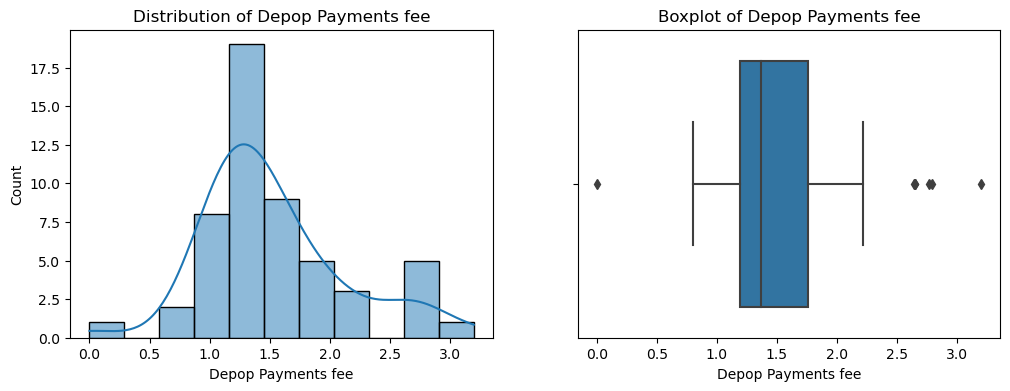

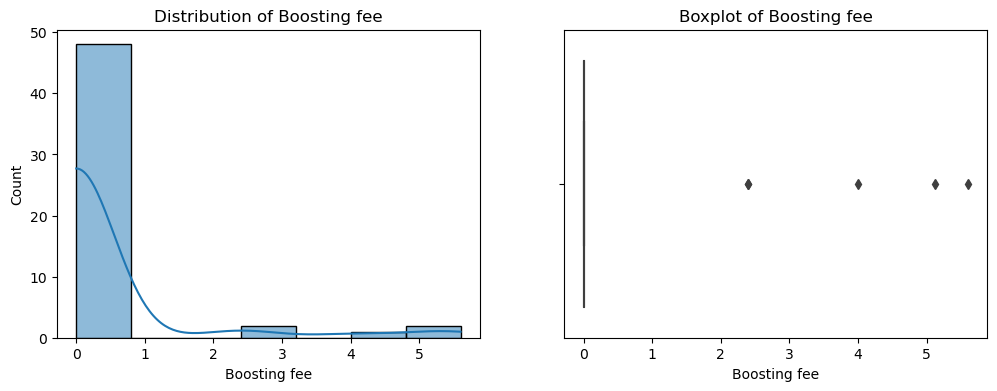

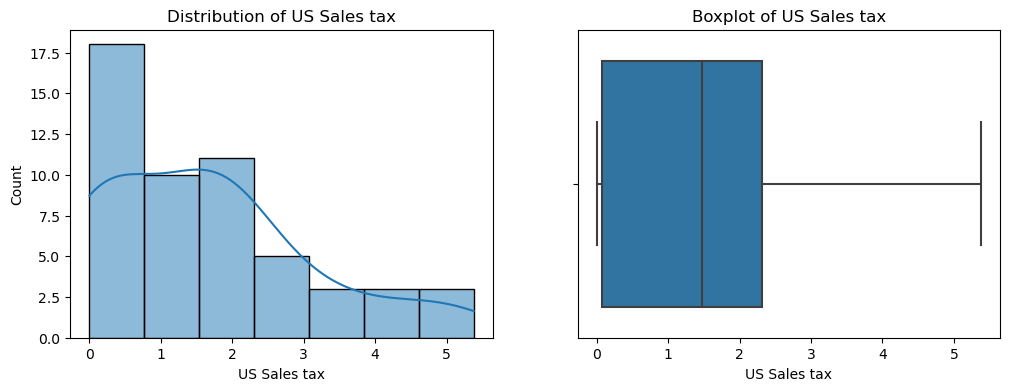

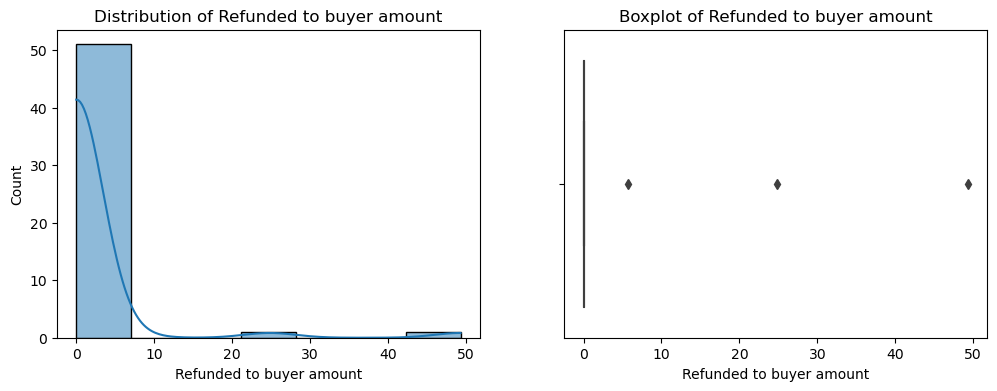

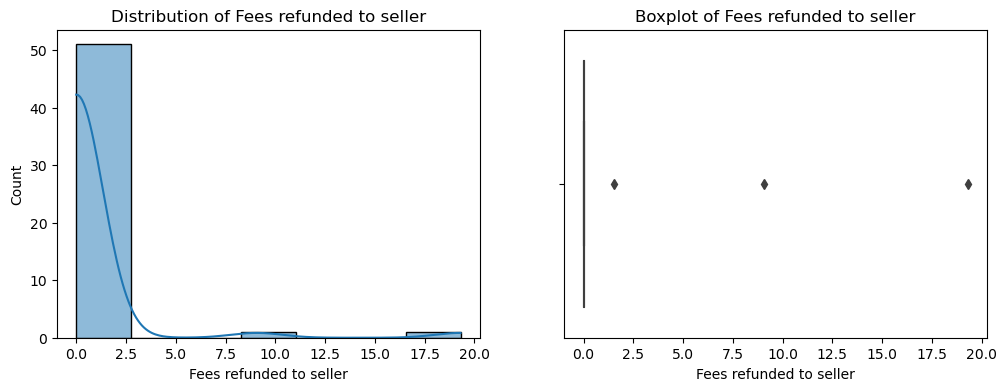

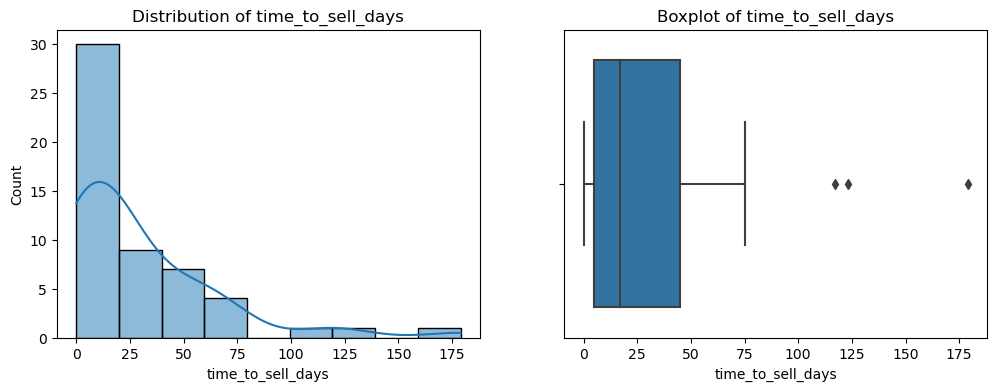

In [29]:
int_float_cols = df.select_dtypes(include=['int', 'int64', 'float', 'float64']).columns

for col in int_float_cols:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

### Univariate Analysis On Categorical Columns

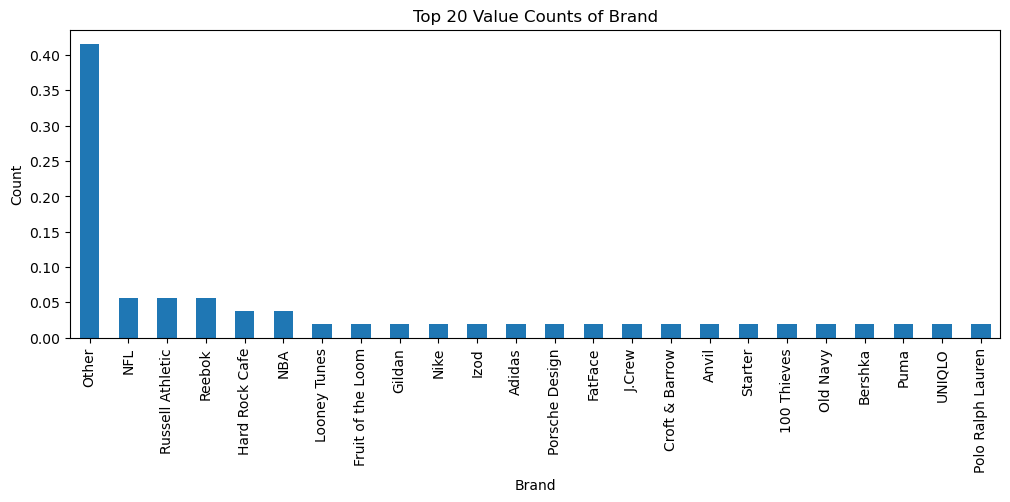

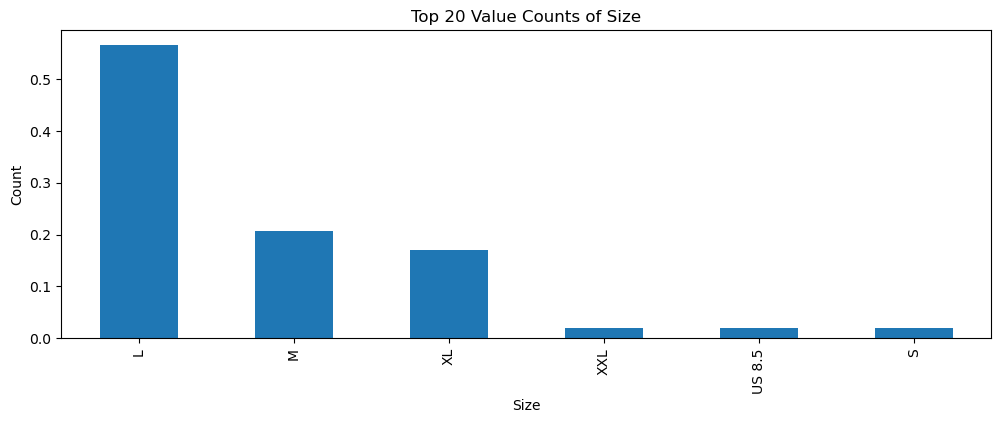

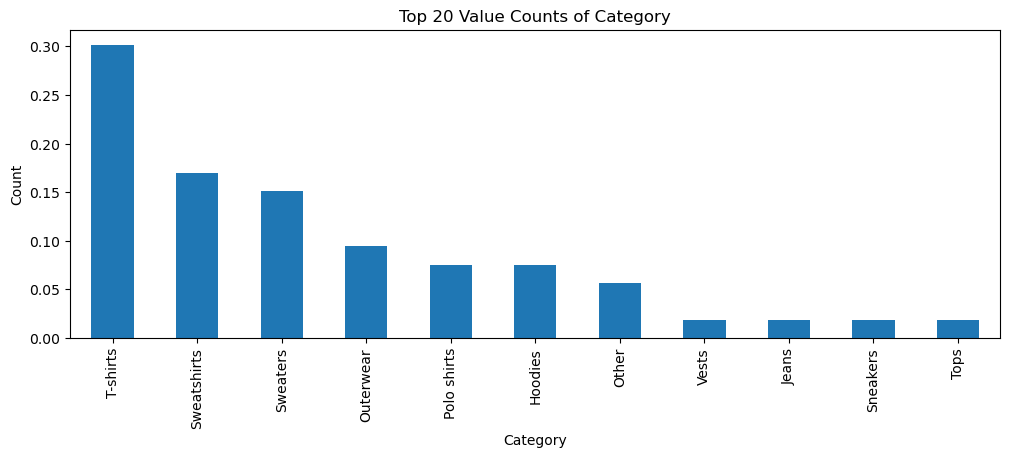

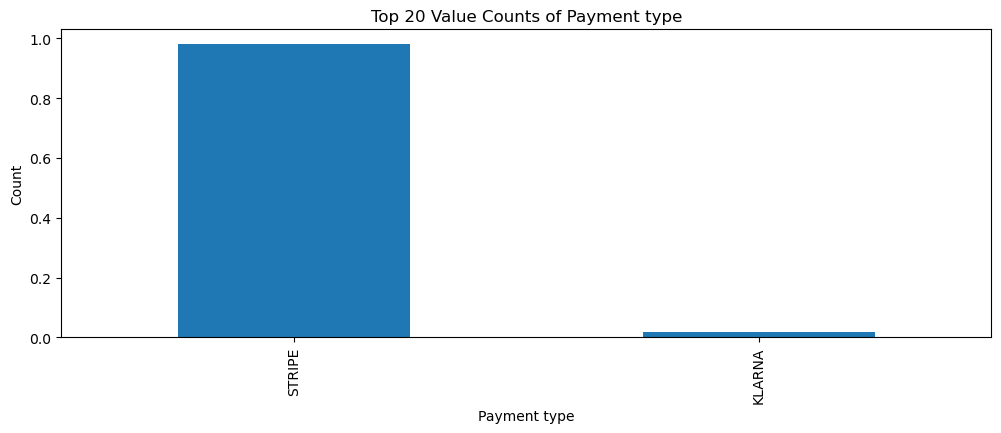

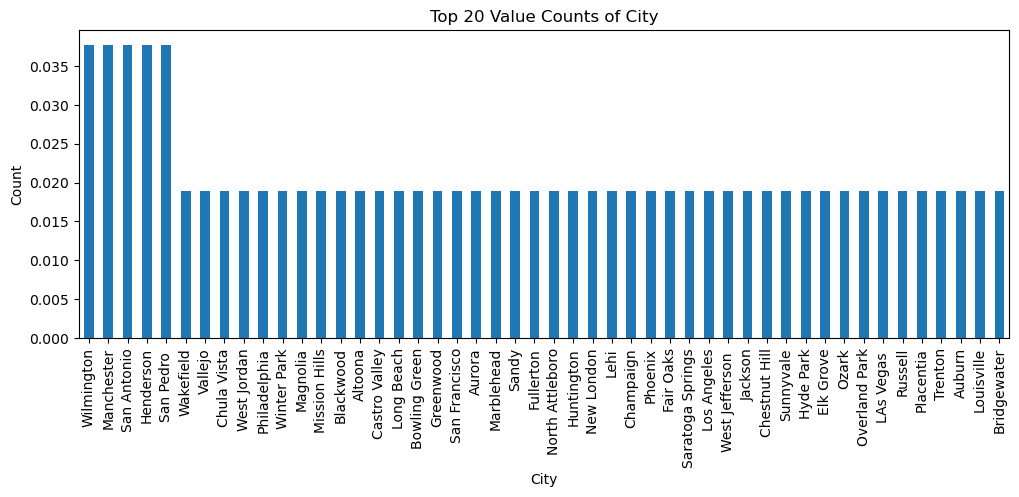

In [30]:
cat_cols = ['Brand', 'Size', 'Category', 'Payment type', 'City']

for col in cat_cols:
    plt.figure(figsize=(12,4))
    df[col].value_counts(20).plot(kind='bar')
    plt.title(f'Top 20 Value Counts of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

### Multivariate Analysis

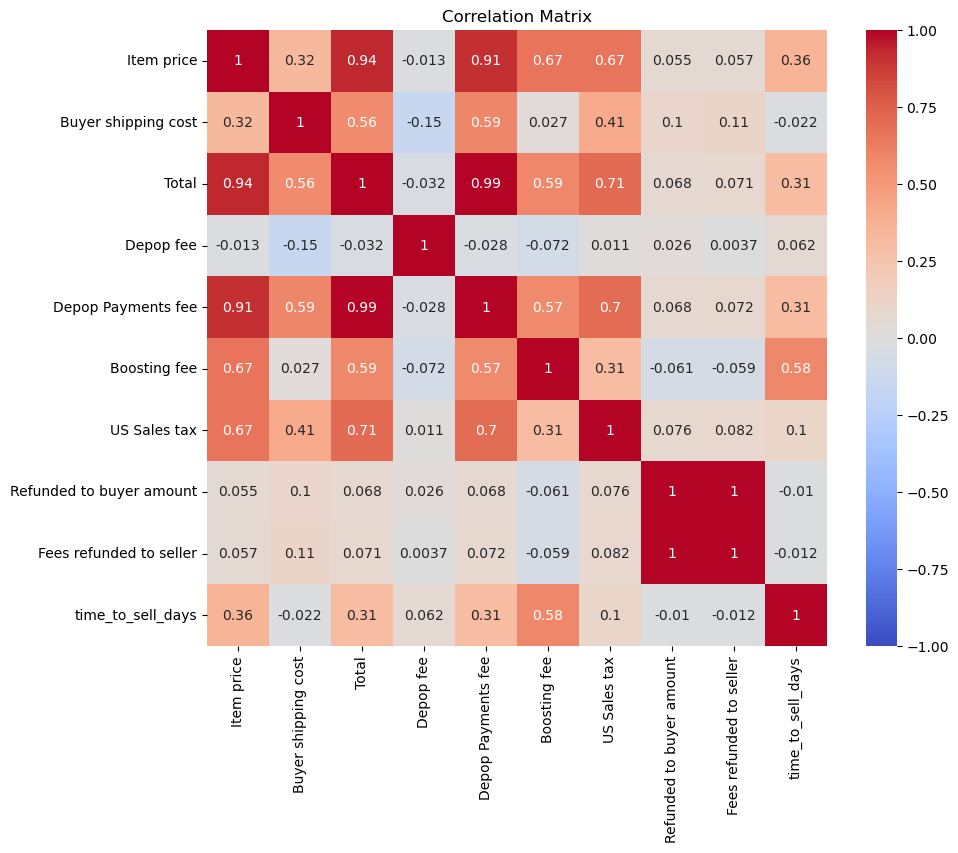

In [31]:
# Correlation matrix
corr = df.corr(numeric_only=True)

# Visualize using a heat map
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

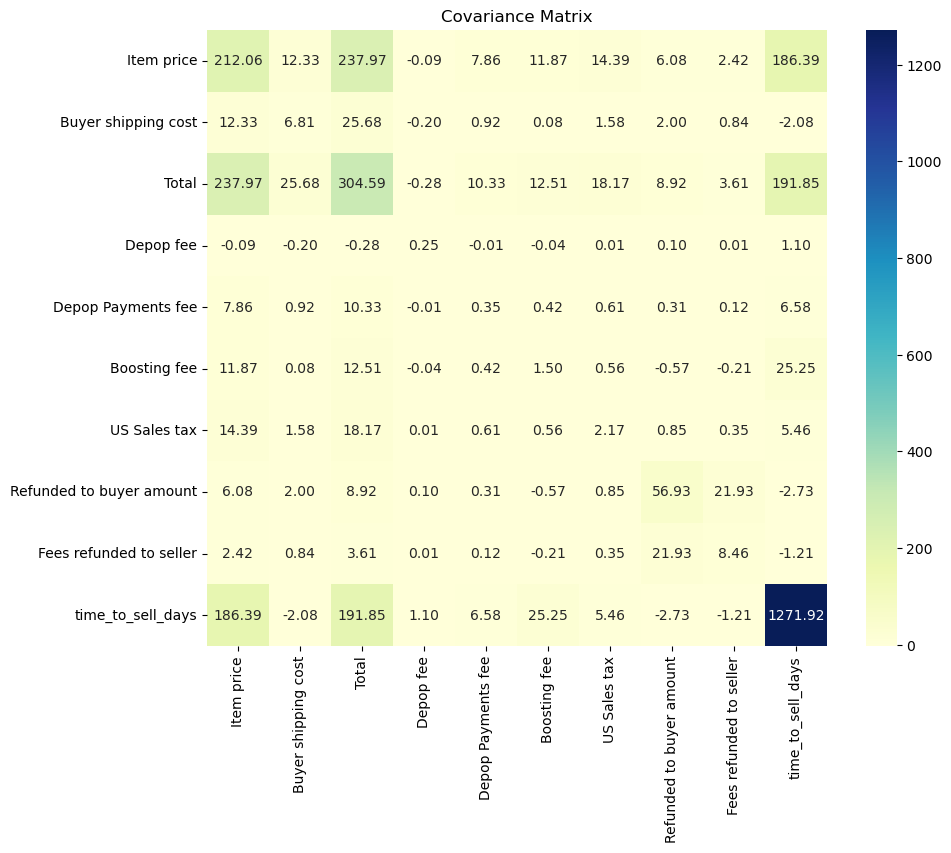

In [32]:
# Covariance Matrix
cov = df.cov(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(cov, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Covariance Matrix')
plt.show()


### Cramers V calculation

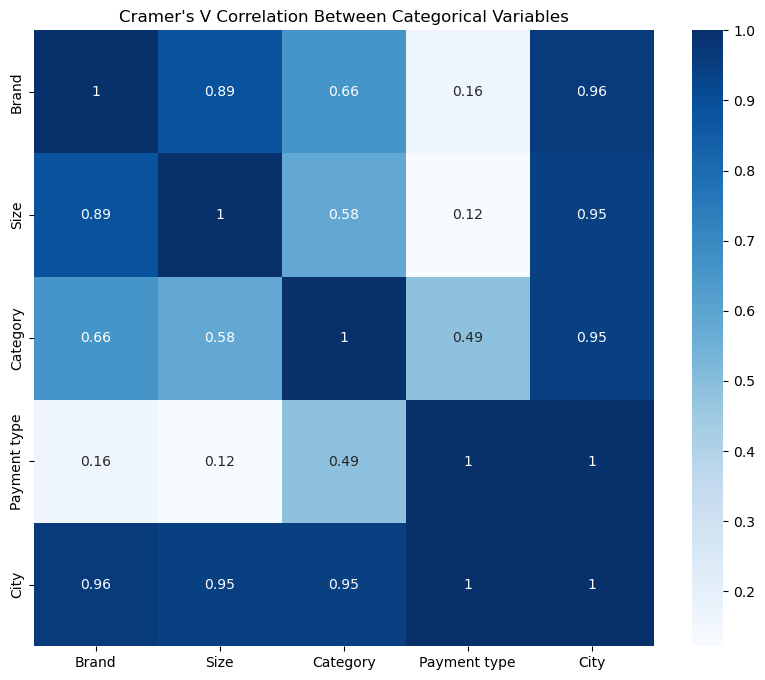

In [33]:
from scipy.stats import chi2_contingency

def cramers_v(x,y):
    """
    Method to perform the cramers v calculation 
    on two categorical variables to measure association
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/ n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

cramers_results = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramers_results.loc[col1, col2] = 1.0
        else:
            n_unique1 = df[col1].nunique()
            n_unique2 = df[col2].nunique()
            if n_unique1 > 1 and n_unique2 > 1:
                cramers_results.loc[col1, col2] = cramers_v(df[col1], df[col2])
            else:
                 cramers_results.loc[col1, col2] = np.nan

cramers_results = cramers_results.astype(float)
plt.figure(figsize=(10,8))
sns.heatmap(cramers_results, annot=True, cmap='Blues')
plt.title("Cramer's V Correlation Between Categorical Variables")
plt.show()

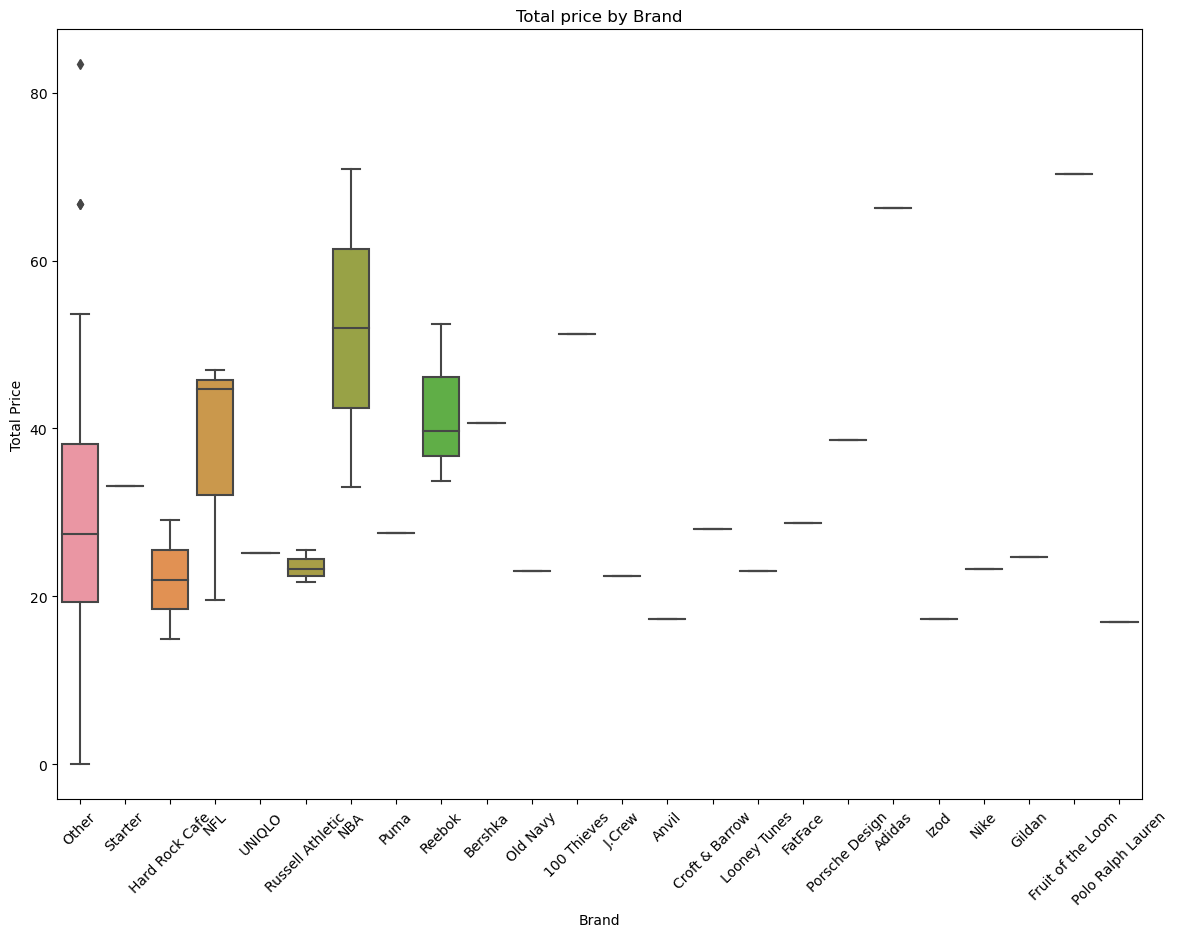

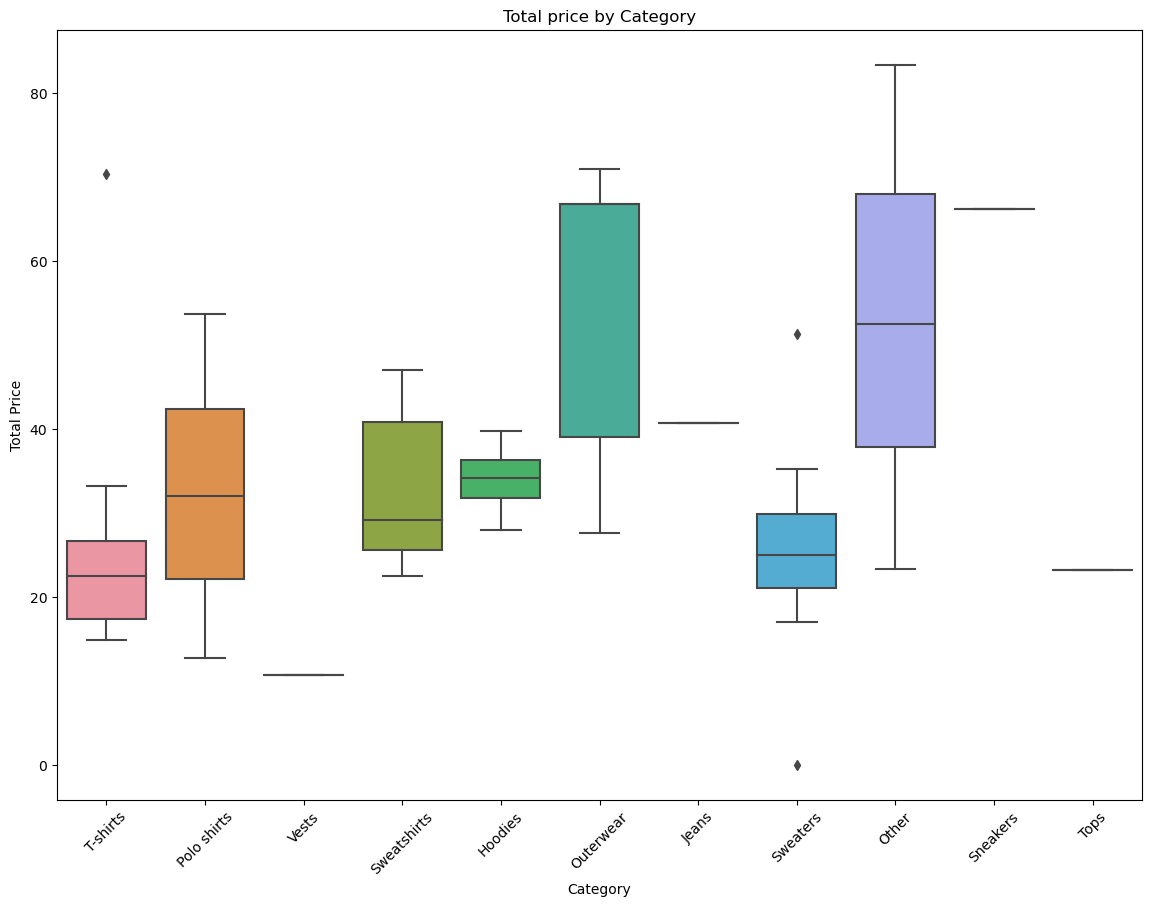

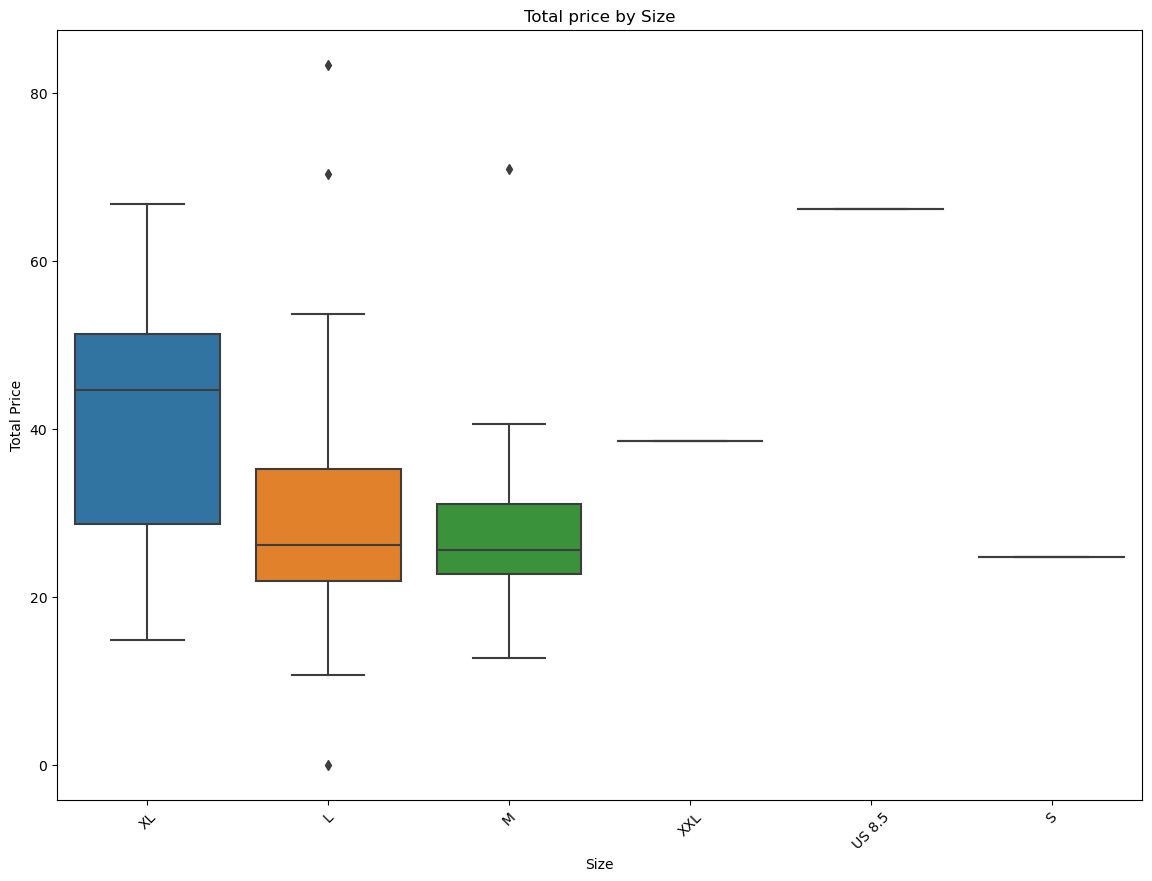

In [34]:
# Analysis between brand, category, and size based on total price

c_cols = ['Brand', 'Category', 'Size', ]
for col in c_cols:
    plt.figure(figsize=(14,10))
    sns.boxplot(x=df[col], y=df['Total'])
    plt.title(f'Total price by {col}')
    plt.xlabel(col)
    plt.ylabel('Total Price')
    plt.xticks(rotation=45)
    plt.show()

### DF For Cost Summary

In [36]:
# Class to create a depop cost analyzer to calculate earnings
class DepopCostAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.summary_df = None
    def build_summary(self):
        cost_cols = [
            'order_id', 'Item price', 'Buyer shipping cost', 
            'Total', 'Depop fee', 'Depop Payments fee',
            'Boosting fee', 'US Sales tax', 'Refunded to buyer amount', 
            'Fees refunded to seller', 'time_to_sell_days'
        ]
        self.summary_df = self.df[cost_cols].copy()
        self.summary_df['Total Fees'] = (
        self.summary_df['Depop fee'] +
        self.summary_df['Depop Payments fee'] +
        self.summary_df['Boosting fee']
        )
        self.summary_df['Net Earnings'] = (
        self.summary_df['Total']
        - self.summary_df['US Sales tax']
        - self.summary_df['Total Fees']
        + self.summary_df['Fees refunded to seller']
        - self.summary_df['Refunded to buyer amount']
        )
        return self.summary_df
    def get_total_profit(self):
        if self.summary_df is None:
                self.build_summary()
        return self.summary_df['Net Earnings']. sum()

# Use 
analyzer = DepopCostAnalyzer(df)
summary_df = analyzer.build_summary()
print(summary_df.head())
print("Total Net Earnings:", analyzer.get_total_profit())

                               order_id  Item price  Buyer shipping cost  \
0  cbef8752-866f-4360-bddf-51670d85e920        24.0                 6.29   
1  2b464657-585b-4d12-9f08-00404bd154c4        25.0                 6.29   
2  ecd8dcfd-ef06-436f-b652-df2704d5f453        10.0                 6.29   
3  3d64014a-df99-4fb1-af74-6e1a6a11747c         8.0                 6.29   
4  f174c217-dad0-4ff9-aa13-9588522390f2         6.0                 6.29   

   Total  Depop fee  Depop Payments fee  Boosting fee  US Sales tax  \
0  31.97        2.4                1.51           0.0          1.68   
1  33.15        2.5                1.54           0.0          1.86   
2  17.08        0.0                1.01           0.0          0.79   
3  14.91        0.0                0.94           0.0          0.62   
4  12.73        0.0                0.87           0.0          0.44   

   Refunded to buyer amount  Fees refunded to seller  time_to_sell_days  \
0                      0.00              

In [37]:
summary_df.describe()

,Item price,Buyer shipping cost,Total,Depop fee,Depop Payments fee,Boosting fee,US Sales tax,Refunded to buyer amount,Fees refunded to seller,time_to_sell_days,Total Fees,Net Earnings
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,22.875472,8.322264,32.826981,0.116981,1.524340,0.368302,1.643561,1.507547,0.563585,28.867925,2.009623,28.229835
std,14.562398,2.609041,17.452486,0.499514,0.595065,1.224000,1.473153,7.545044,2.908937,35.664051,1.682220,15.564313
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.060000
25%,14.000000,6.290000,22.460000,0.000000,1.190000,0.000000,0.070000,0.000000,0.000000,5.000000,1.210000,18.500000
50%,17.300000,7.990000,27.920000,0.000000,1.370000,0.000000,1.470000,0.000000,0.000000,17.000000,1.370000,23.950000
75%,25.000000,11.690000,39.690000,0.000000,1.760000,0.000000,2.310000,0.000000,0.000000,45.000000,2.140000,34.900000
max,70.000000,11.690000,83.370000,2.500000,3.200000,5.600000,5.380000,49.300000,19.300000,179.000000,8.800000,69.190000


In [ ]:
# Save to SQLite database
import sqlite3
conn = sqlite3.connect("data/processed/sales.db")
summary_df.to_sql("summary", conn, if_exists="replace", index=False)
conn.close()

### Find the correlation between the Net Earnings and the time it takes to sell an item

/Users/isaganijulian/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


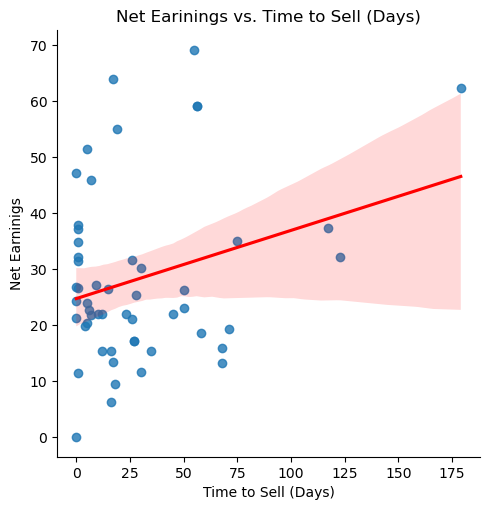

In [38]:
# Scatter plot for the findings

sns.lmplot(
    data=summary_df,
    x=  'time_to_sell_days',
    y = 'Net Earnings',
    line_kws={'color': 'red'}
)
plt.title('Net Earinings vs. Time to Sell (Days)')
plt.xlabel('Time to Sell (Days)')
plt.ylabel('Net Earninigs')
plt.show()

### Cluster by category, time to sell, and Net earinngs

/Users/isaganijulian/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


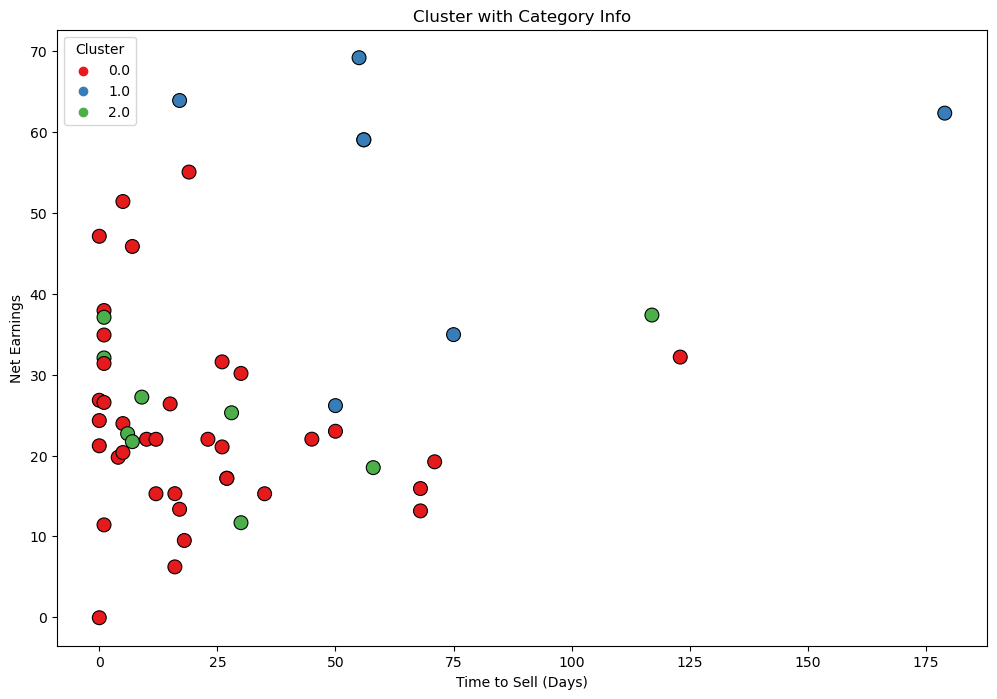

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cluster_df= summary_df.merge(
df[['order_id', 'Category']],
on='order_id', how='left'
)
# One-Hot encoding
cluster_df = pd.get_dummies(cluster_df, columns=['Category'])

# Select columns for clustering
feature_cols = ['time_to_sell_days', 'Net Earnings'] + [col for col in 
cluster_df.columns if col.startswith('Category_')]
X = cluster_df[feature_cols].dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster using KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
cluster_df.loc[X.index, 'Cluster'] = clusters

# Visualize the cluster
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=cluster_df,
    x='time_to_sell_days',
    y='Net Earnings',
    hue='Cluster',
    palette='Set1',
    s=100,
    edgecolor='k'
)
plt.title('Cluster with Category Info')
plt.xlabel('Time to Sell (Days)')
plt.ylabel('Net Earnings')
plt.legend(title='Cluster')
plt.show()

In [40]:
# Basic cluster summary statistics
cluster_summary = cluster_df.groupby('Cluster').agg(
    count=('Net Earnings', 'size'),
    avg_net_earnings=('Net Earnings', 'mean'),
    avg_time_to_sell=('time_to_sell_days', 'mean'),
    min_net_earnings=('Net Earnings', 'min'),
    max_net_earnings=('Net Earnings', 'max'),
    min_time_to_sell=('time_to_sell_days', 'min'),
    max_time_to_sell=('time_to_sell_days', 'max')
).reset_index()

print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
   Cluster  count  avg_net_earnings  avg_time_to_sell  min_net_earnings  \
0      0.0     37         23.998007         21.216216             -0.06   
1      1.0      7         53.518214         69.714286             26.17   
2      2.0      9         25.958611         28.555556             11.69   

   max_net_earnings  min_time_to_sell  max_time_to_sell  
0             55.05                 0               123  
1             69.19                17               179  
2             37.37                 1               117  


In [41]:
df.head(5)

,Date of sale,Time of sale,Date of listing,Bundle,Brand,Description,Size,Item price,Buyer shipping cost,Total,...,Category,City,State,Post Code,Country,US Sales tax,Refunded to buyer amount,Fees refunded to seller,order_id,time_to_sell_days
0,2024-07-01,7:16 PM,2024-06-16,No,Other,Limited NYC 2023 Dragon Ball Daima Special Pan...,XL,24.0,6.29,31.97,...,T-shirts,Altoona,Iowa,50009-2688,US,1.68,0.00,0.00,cbef8752-866f-4360-bddf-51670d85e920,15
1,2024-08-05,10:39 PM,2024-06-16,No,Starter,90s Vintage Starter Denver Broncos Superbowl X...,L,25.0,6.29,33.15,...,T-shirts,Lehi,Utah,84043,US,1.86,5.76,1.51,2b464657-585b-4d12-9f08-00404bd154c4,50
2,2024-08-06,3:13 AM,2024-07-21,No,Other,NYPD shirt\n\nSize: Medium\nMeasurements: 20 W...,M,10.0,6.29,17.08,...,T-shirts,Phoenix,Arizona,85048-8746,US,0.79,0.00,0.00,ecd8dcfd-ef06-436f-b652-df2704d5f453,16
3,2024-08-07,4:42 AM,2024-07-21,No,Hard Rock Cafe,Hard Rock Cafe grey and white shirt\n\nSize: L...,L,8.0,6.29,14.91,...,T-shirts,Fair Oaks,California,95628-5529,US,0.62,0.00,0.00,3d64014a-df99-4fb1-af74-6e1a6a11747c,17
4,2024-08-08,2:05 AM,2024-08-07,No,Other,Polo shirt\n\nSize: Medium,M,6.0,6.29,12.73,...,Polo shirts,Saratoga Springs,Utah,84045-8154,US,0.44,0.00,0.00,f174c217-dad0-4ff9-aa13-9588522390f2,1
